# Metropolis Hasting Ising Model HW
---

Problem 15.12. Equilibration of the two-dimensional Ising model.

### (a)
Write a target class that uses class Ising and plots the magnetization and energy as a function of the number of Monte Carlo steps. Your program should also display the mean magnetization, the energy, the specific heat, the susceptibility, and the acceptance probability when the simulation is stopped. Averages such as the mean energy and the susceptibility should be normalized by the number of spins so that it is easy to compare systems with different values of N . Choose the linear dimension L = 32 and the heat bath temperature T = 2. Estimate the time needed to equilibrate the system given that all the spins are initially up.

In [27]:
import numpy as np
from time import sleep
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

class IsingMCMC:

    def __init__(self, temperature, L=32, random=False):

        self.random = random
        self.critical_temperature = 2.0/np.log(1.0 + np.sqrt(2.0))
        self.L = L
        self.N = self.L ** 2
        self.temperature = temperature
        self. mcs = 0
        self.energy = -2 * self.N
        self.phase = "Ordered" if temperature <= self.critical_temperature else "Disordered"
        self.time_to_eq = 0

        self.energy_accumulator = 0.0
        self.energy_squared_accumulator = 0.0

        self.magnetization = self.N
        self.magnetization_accumulator = 0.0
        self.magnetization_squared_accumulator = 0.0

        self.accepted_moves = 0

        # lists for plots
        self.energy_list = []
        self.magnetization_list = []
        self.specific_heat_list = []
        self.susceptibility_list = []
        self.accepted_moves_list = []

        self.w = {4: np.exp(-4.0 / self.temperature),
                  8: np.exp(-8.0/ self.temperature)}

        self.lattice = np.random.choice([-1,1], self.N).reshape((L, L)) if random else np.ones((L, L), dtype=np.int8)

    def reset(self, temperature=None, L=None, random=None):
        """
        Reinitialize simulation object.

        :return: None
        """
        temperature = temperature if temperature is not None else self.temperature
        L = L if L is not None else self.L
        random = random if random is not None else self.random

        self.__init__(temperature=temperature, L=L, random=random)

        return None

    def specific_heat(self):
        """
        Computes current specific heat of the system.

        :return: (float) specific heat
        """
        energy_squared_avg = self.energy_squared_accumulator / self.mcs
        energy_avg = self.magnetization_accumulator / self.mcs
        heat_capacity = energy_squared_avg - energy_avg ** 2
        heat_capacity = heat_capacity / (self.temperature ** 2)

        return heat_capacity / self.N

    def susceptibility(self):
        """
        Compute susceptibility of the system.

        :return: (float) susceptibility
        """
        magnetization_squared_avg = self.magnetization_squared_accumulator / self.mcs
        magnetization_avg = self.magnetization_accumulator / self.mcs
        susceptibility = magnetization_squared_avg - magnetization_avg ** 2

        return susceptibility / (self.temperature * self.N)

    def MCS_step(self):
        """
        Iterate through all particles to complete one MCS step

        :return: None
        """
        for _ in range(self.N):
            i = np.random.randint(self.L)
            j = np.random.randint(self.L)
            delta_E = 2 * self.lattice[i][j] * (self.lattice[(i+1)%self.L][j] + self.lattice[(i-1+self.L)%self.L][j] + self.lattice[i][((j+1)%self.L)] + self.lattice[i][((j-1+self.L)%self.L)])
            if delta_E <= 0 or self.w[delta_E] > np.random.random_sample():
                new_spin = -self.lattice[i][j]
                self.lattice[i][j] = new_spin
                self.accepted_moves += 1
                self.energy += delta_E
                self.magnetization += 2 * new_spin

        self.mcs += 1

        self.energy_accumulator += self.energy
        self.energy_squared_accumulator += self.energy ** 2
        self.magnetization_accumulator += self.magnetization
        self.magnetization_squared_accumulator += self.magnetization ** 2


        self.energy_list.append(self.energy)
        self.magnetization_list.append(self.magnetization)
        self.specific_heat_list.append(self.specific_heat())
        self.susceptibility_list.append(self.susceptibility())
        self.accepted_moves_list.append(self.accepted_moves)


        # check for equilibrium
        if not self.equilibrium():
            self.time_to_eq += 1

        return None

    def equilibrium(self):
        """
        Calculates if the system is at equilibrium.

        :return: True if at equilibrium else False
        """
        look_back = 25
        threshold = 0.05

        if self.mcs > 2 * look_back:
            old_mean = np.sum(self.specific_heat_list[-(2*look_back):-look_back]) / look_back
            new_mean = np.sum(self.specific_heat_list[-look_back: self.mcs]) / look_back
            ratio = np.abs(new_mean / old_mean) % 1

            return True if ratio <= threshold else False

        else:
            return False

    def simulate(self, simulations):
        """
        Simulate without animation.

        :param simulations: number of MCMC iterations
        :return: None
        """

        for _ in range(simulations):
            self.MCS_step()

        return None

    def animate(self, simulations):
        """
        Iterate for given MCS steps.

        :param simulations: number of MCMC iterations
        :return: None
        """
        for _ in range(simulations):
            fig = plt.figure(figsize=(12,8))
            gs = fig.add_gridspec(2,3, wspace=0.5, hspace=0.2)
            axs = gs.subplots()
            self.plot(fig, axs)
            self.MCS_step()
            sleep(0.01)
            clear_output(wait=True)

        self.plot(fig, axs)


        return None

    def plot(self, fig, ax):
        """
        Plot current lattice configuration.

        :return: None
        """

        pcm = ax[0][0].pcolormesh(self.lattice)
        fig.colorbar(pcm, ax=ax[0][0])

        ax[0][1].set(ylabel="Energy")
        ax[0][1].plot(np.arange(self.mcs), self.energy_list)

        ax[0][2].set(ylabel="Magnetization")
        ax[0][2].plot(np.arange(self.mcs), self.magnetization_list)


        ax[1][0].set(xlabel="MCS", ylabel="Susceptibility")
        ax[1][0].plot(np.arange(self.mcs), self.susceptibility_list)

        ax[1][1].set(xlabel="MCS", ylabel="Specific Heat")
        ax[1][1].plot(np.arange(self.mcs), self.specific_heat_list)

        ax[1][2].set(xlabel="MCS", ylabel="Acceptance")
        ax[1][2].plot(np.arange(self.mcs), self.accepted_moves_list)

        plt.show()

        return None

    @property
    def summary(self):
        """
        Displays a summary of the system.

        :return: None
        """
        mean_mag = np.sum(self.magnetization_list[-25: self.mcs]) / 25 / self.N
        mean_eng = np.sum(self.energy_list[-25: self.mcs]) / 25 / self.N
        mean_spec_ht = np.sum(self.specific_heat_list[-25: self.mcs]) / 25 / self.N
        mean_sus = np.sum(self.susceptibility_list[-25: self.mcs]) / 25 / self.N

        eq_state = self.time_to_eq if self.equilibrium else "Not in equilibrium."

        print("Summary over last 25 MCS steps normalized by number of particles.\n"
              "Temperature: {}\n"
              "System is {}\n"
              "Time to equilibrium: {}\n"
              "Mean Magnetization: {}\n"
              "Mean Energy: {}\n"
              "Mean Specific Heat: {}\n"
              "Mean Susceptibility: {}\n".format(self.temperature, self.phase, eq_state, mean_mag, mean_eng, mean_spec_ht, mean_sus))


        plt.hist(self.accepted_moves_list, bins=20, density=True)
        plt.title("Acceptance Probability Density Function")
        plt.ylabel("Observed Probability Density")
        plt.xlabel("MCS step")
        plt.show()

        return None

    def phase_summary_vals(self, MC_steps):
        """
        Calculates summery values.

        :return: (dict) summary values
        """
        mean_mag = self.magnetization / self.N
        mean_eng = self.energy / self.N
        mean_spec_ht = self.specific_heat() / self.N
        mean_sus = self.susceptibility() / self.N

        return {"mag": mean_mag, "eng": mean_eng, "heat": mean_spec_ht, "suscept": mean_sus}

    def analyze(self):

        self.reset()
        steps_to_eq = []
        num_sim = 20
        sim_length = 300
        for _ in range(num_sim):
            self.simulate(sim_length)
            steps_to_eq.append(self.time_to_eq)
            self.reset()

        mean = np.mean(steps_to_eq)
        std = np.std(steps_to_eq)
        print("Estimated MCMC steps to equilibrium for T=2 over {} simulations.\n"
              "Mean: {}\n"
              "Std: {}".format(num_sim, mean, std))


        plt.hist(steps_to_eq, bins=10)
        plt.title("MCMC steps to equilibrium")
        plt.ylabel("Num simulations")
        plt.xlabel("MCMC steps")
        plt.show()

        return None

    def phase_analysis(self):
        x = np.flip(np.linspace(1.5, 3.5, 11))
        MC_steps = 3000

        energy = []
        mag = []
        spec_heat = []
        suscept = []
        eq_time = []

        for value in x:
            self.reset(temperature=value, random=True)
            # self.temperature = value
            self.simulate(simulations=MC_steps)
            summary = self.phase_summary_vals(MC_steps)
            energy.append(summary["eng"])
            mag.append(summary["mag"])
            spec_heat.append(summary["heat"])
            suscept.append(summary["suscept"])
            eq_time.append(self.time_to_eq)
            self.time_to_eq = 0

        fig = plt.figure(figsize=(12,8))
        gs = fig.add_gridspec(2,3, wspace=0.5, hspace=0.2)
        axs = gs.subplots()

        axs[0][0].set(ylabel="Energy")
        axs[0][0].plot(x, energy, 'yo')

        axs[0][1].set(ylabel="Magnetization")
        axs[0][1].plot(x, mag, 'bo')

        axs[0][2].set(ylabel="Absolute Magnetization")
        axs[0][2].plot(x, np.abs(mag), 'bo')


        axs[1][0].set(xlabel="Temperature", ylabel="Susceptibility")
        axs[1][0].plot(x, suscept, 'go')

        axs[1][1].set(xlabel="Temperature", ylabel="Specific Heat")
        axs[1][1].plot(x, spec_heat, 'ro')

        axs[1][2].set(xlabel="Temperature", ylabel="Time to Equilibrium")
        axs[1][2].plot(x, eq_time, 'co')

        plt.show()




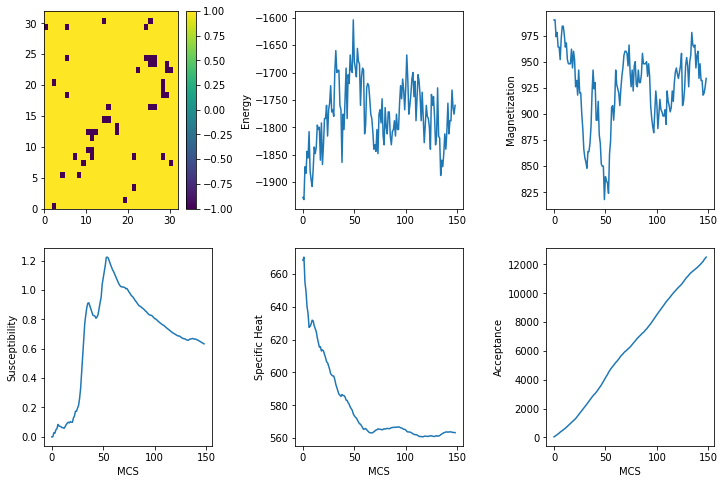

In [28]:
sim = IsingMCMC(temperature=2)
sim.animate(150)

Summary of one simulation. Equilibrium is defined as mean specific heat varying <= 5% over the previous 50 MCMC steps.

Summary over last 25 MCS steps normalized by number of particles.
Temperature: 2
System is Ordered
Time to equilibrium: 137
Mean Magnetization: 0.919765625
Mean Energy: -1.7546875
Mean Specific Heat: 0.5494521524686067
Mean Susceptibility: 0.0006440809654251467



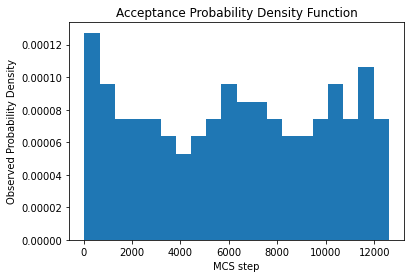

In [29]:
sim.summary

Estimated MCMC steps to equilibrium for T=2 over 20 simulations.
Mean: 209.95
Std: 37.887299982975826


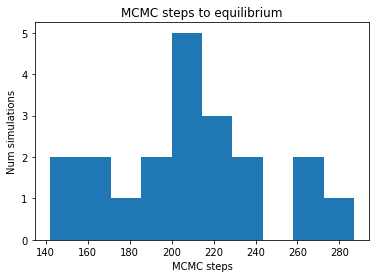

In [30]:
sim.analyze()

### (b)
Visually determine if the spin configurations are “ordered” or “disordered” at T = 2 after equilibrium has been established.

---
Answer: Visually, spin configurations appear to be ordered at T=2

### (c)
Repeat part (a) with the initial direction of each spin chosen at random. Make sure you explicitly compute the initial energy and magnetization in initialize. Does the equilibration time increase or decrease?

___
Answer: Equilibrium time appears to decrease with a random initialization

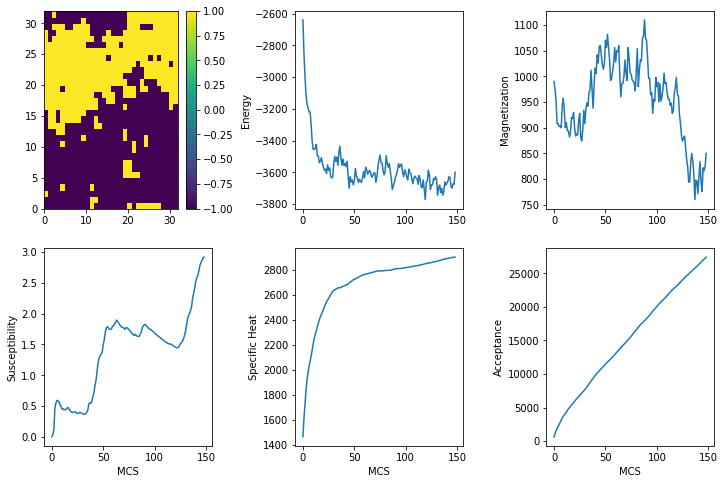

In [31]:
random_sim = IsingMCMC(temperature=2, random=True)
random_sim.animate(150)

Summary over last 25 MCS steps normalized by number of particles.
Temperature: 2
System is Ordered
Time to equilibrium: 69
Mean Magnetization: 0.804921875
Mean Energy: -3.5859375
Mean Specific Heat: 2.8176216945853256
Mean Susceptibility: 0.0021898057031982422



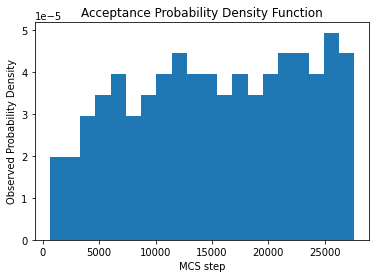

In [32]:
random_sim.summary

Estimated MCMC steps to equilibrium for T=2 over 20 simulations.
Mean: 98.7
Std: 37.69495987529368


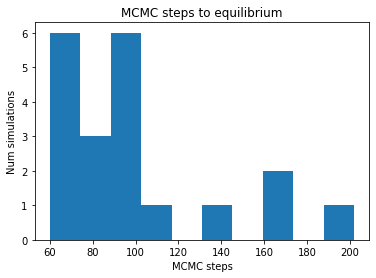

In [33]:
random_sim.analyze()

### (d)
Repeat parts (a)–(c) for T = 2.5.

### (a) T= 2.5
Initialized all up, T = 2.5

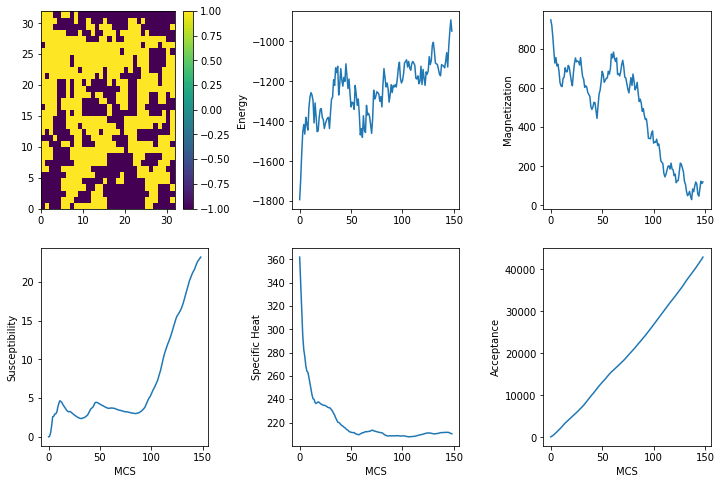

In [34]:
sim = IsingMCMC(temperature=2.5)
sim.animate(150)

Summary over last 25 MCS steps normalized by number of particles.
Temperature: 2.5
System is Disordered
Time to equilibrium: 127
Mean Magnetization: 0.10265625
Mean Energy: -1.05171875
Mean Specific Heat: 0.20599579168110893
Mean Susceptibility: 0.019254526835137332



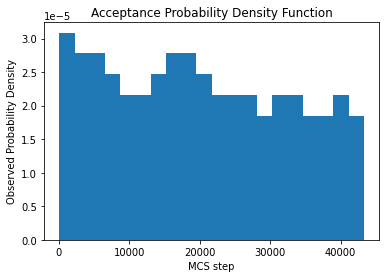

In [35]:
sim.summary

### (b) T = 2.5
Visually determine if the spin configurations are “ordered” or “disordered” at T = 2 after equilibrium has been established.

---
Answer: Visually, spin configurations appear to be disordered at T=2.5

Estimated MCMC steps to equilibrium for T=2 over 20 simulations.
Mean: 210.55
Std: 40.18143227910125


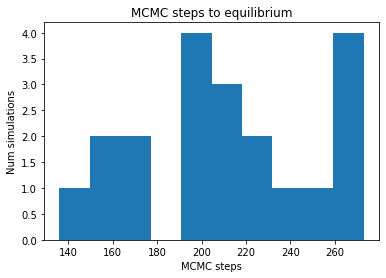

In [36]:
sim.analyze()

### (c)
Initialize random, T = 2.5

---
Answer: Equilibrium time still appears to decrease with T = 2.5 and random initialization but the distribution is noticeably different.

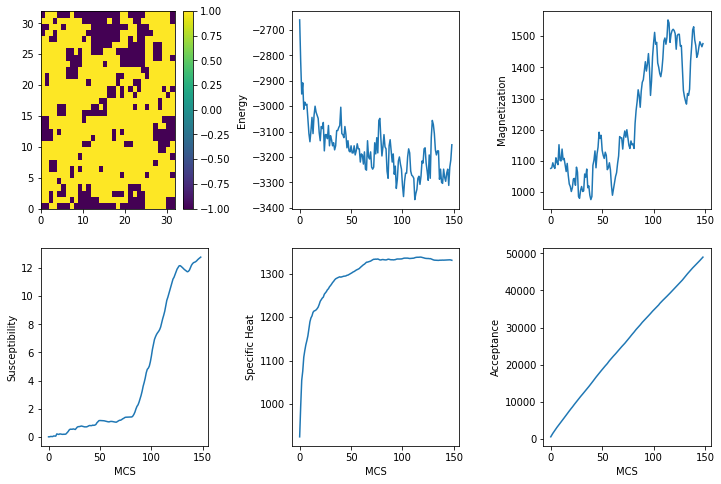

In [37]:
random_sim = IsingMCMC(temperature=2.5, random=True)
random_sim.animate(150)

Summary over last 25 MCS steps normalized by number of particles.
Temperature: 2.5
System is Disordered
Time to equilibrium: 70
Mean Magnetization: 1.393828125
Mean Energy: -3.14390625
Mean Specific Heat: 1.3003067643235204
Mean Susceptibility: 0.011926654926523275



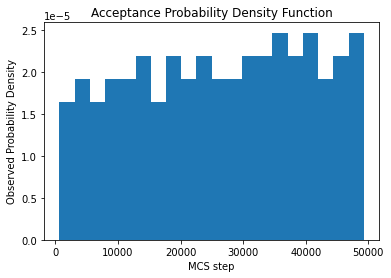

In [38]:
random_sim.summary

Estimated MCMC steps to equilibrium for T=2 over 20 simulations.
Mean: 154.2
Std: 56.128067844884875


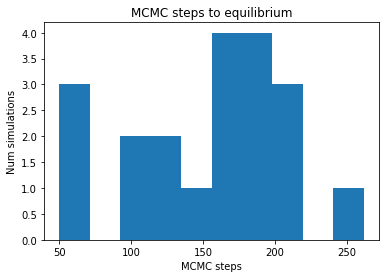

In [39]:
random_sim.analyze()



Problem 15.16. Qualitative behavior of the two-dimensional Ising model

### (a)
Use class Ising and your version of IsingApp to compute the mean magnetization, the mean energy, the heat capacity, and the susceptibility. Because we will consider the Ising model for different values of L, it will be convenient to convert these quantities to intensive quantities such as the mean energy per spin, the specific heat (per spin), and the susceptibility per spin. For simplicity, we will use the same notation for both the extensive and the corresponding intensive quantities. Choose L = 4 and consider T in the range 1.5 ≤ T ≤ 3.5 in steps of ∆T = 0.2. Choose the initial condition at T = 3.5 such that the orientation of the spins is chosen at random. Because all the spins might overturn and the magnetization would change sign during the course of your observation, estimate the mean value of |M| in addition to that of M. The susceptibility should be calculated as

χ = 1/kT [<M**2> − <|M|>**2 ] (see code and textbook for clarity)

Use at least 1000 Monte Carlo steps per spin and estimate the number of equilibrium configurations needed to obtain hMi and hEi to 5% accuracy. Plot hEi, m, |m|, C, and χ as a function of T and describe their qualitative behavior. Do you see any evidence of a phase transition?


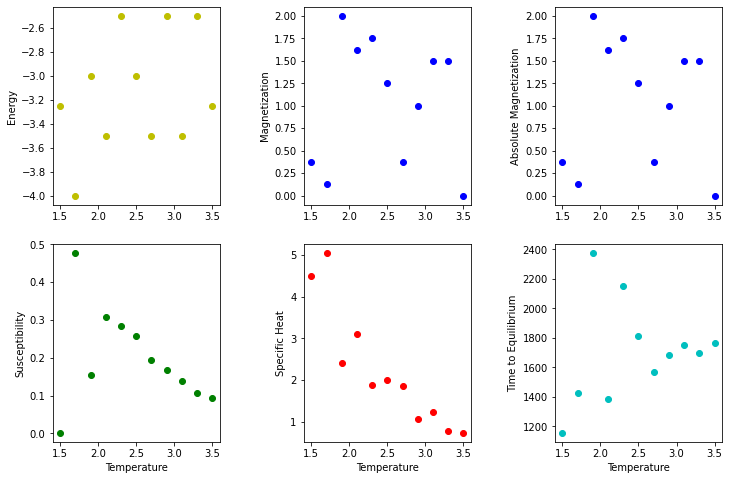

In [40]:
L = 4
phase_sim = IsingMCMC(temperature=3.5, L=L, random=True)
phase_sim.phase_analysis()

---
Answer: Energy and temperature appear to be positively correlated. There is evidence of a phase transition in the susceptibility
plot but not in the specific heat plot.

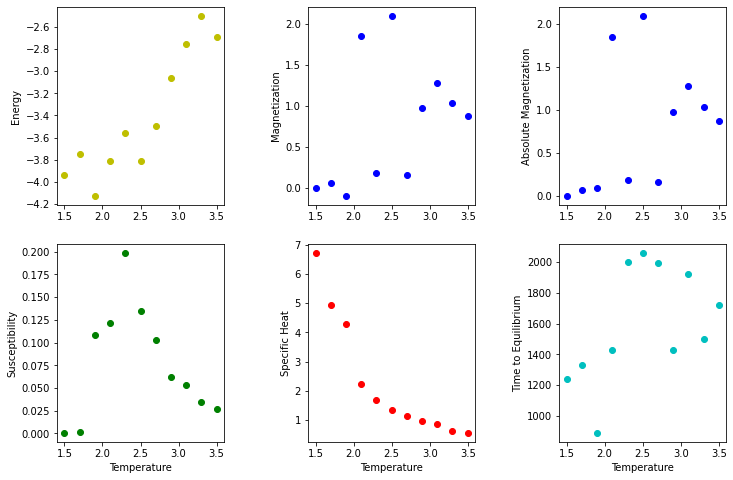

In [41]:
L = 8
phase_sim = IsingMCMC(temperature=3.5, L=L, random=True)
phase_sim.phase_analysis()

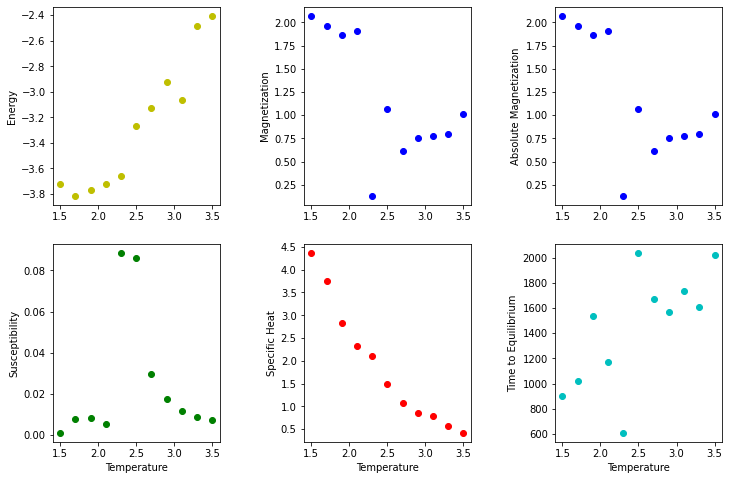

In [42]:
L = 16
phase_sim = IsingMCMC(temperature=3.5, L=L, random=True)
phase_sim.phase_analysis()

---
Answer: Energy and temperature still appear to be positively correlated with increased lattice size.
There also appears to be a weak positive correlation between temperature and time to equilibrium with increased lattice size.
Susceptibility still shows evidence of a phase transition. For reasons unknown to me, I can not duplicate the specific heat plot
presented in the book demonstrating phase change.
plot but not in the specific heat plot.


